## Imports

In [2]:
import os
import pathlib
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

import pickle

from PIL import Image
import cv2

import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torch.autograd import Variable
import torch.autograd as autograd
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import save_image

c:\Anaconda\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Anaconda\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


## Data-Handling

In [3]:
# Data handling constants
TRAIN_DIR = './data_map_cutouts/train3' 
BATCH_SIZE = 32

In [4]:
# The actual Data handling

# Some transformations to apply to the dataset
to_tensor = transforms.ToTensor()                       # Convert it to a tensor
random_flips_v = transforms.RandomVerticalFlip(0.5)     # Flip it vertically with prob. 0.5
random_flips_h = transforms.RandomHorizontalFlip(0.5)   # Flip it horizontally with prob 0.5
to_grayscale = transforms.Grayscale(1)                  # Convert the image to a single channel image

# Composing the transformations
transform = transforms.Compose([
    to_grayscale,
    to_tensor,
    random_flips_h,
    random_flips_v
])

# Creating the dataLoader
train_dir = pathlib.Path(TRAIN_DIR)                         # The directory 
train_data = datasets.ImageFolder(root      = train_dir,    # The dataset
                                  transform = transform)
train_dataLoader = DataLoader(dataset = train_data,         # The dataLoader (batches and shuffles the data)
                     batch_size = BATCH_SIZE, 
                     shuffle    = True,
                     drop_last  = True)


Shape of images from dataLoader: torch.Size([32, 1, 128, 128])


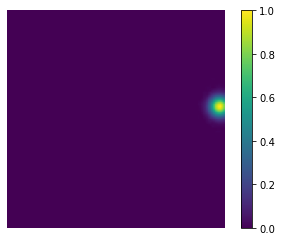

In [5]:
# Sampling from the dataset
images, labels = next(iter(train_dataLoader))
print("Shape of images from dataLoader:", images.shape)

# Displaying a sample input image
plt.imshow(images[0, 0, :, :].detach().cpu().numpy())
plt.axis('off')
plt.colorbar()
plt.show()

In [6]:
print(len(train_dataLoader) * BATCH_SIZE)

9984


## DCGAN

In [7]:
# ---------- IMPORTANT CONSTANTS ----------
# Model Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LATENT_DIM = 2

# Training parameters
N_EPOCHS = 100
N_CRITICS = 1
SAMPLE_INTERVALS = 100
SAVE_INTERVAL = 50
DUMPING_INTERVAL = 1000
LEARNING_RATE = 1e-4
BETAS = (0.5, 0.9)
L_GP = 10.0     # Weight of the Gradient Policy cost
L_l1 = 0.0      # Weight of the L1 norm cost

# Data handling
SAVING_DIR = 'datasets_for_Statistician/single_Gaussian_Blobs_DCGAN/generated_data/' 
os.makedirs(SAVING_DIR, exist_ok=True)
BATCHES_TO_SAVE = 5


In [8]:
# ---------- SOME IMPORTANT LAYERS ----------
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape
        # print(shape)

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)


class LinearFeature(nn.Module):
    __constants__ = ['in_features', 'out_features']

    def __init__(self, in_features, out_features, bias=True):
        super(LinearFeature, self).__init__()
        assert(out_features == in_features)
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(out_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()


    def reset_parameters(self):
        nn.init.normal_(self.weight,1,0.02)
        if self.bias is not None:
            nn.init.normal_(self.bias,0,0.02)
    
    def forward(self, input):
        device = torch.device("cuda" if input.is_cuda else "cpu")
        eye = nn.Parameter(torch.zeros(input.shape), requires_grad=False).to(device=device)
        idxes = np.arange(input.shape[-1])
        eye[...,idxes, idxes] = 1.
        mat_weight = torch.einsum("i,...ijk->...ijk", self.weight, eye)

        if self.bias is not None:
            ones = nn.Parameter(torch.ones(input.shape), requires_grad=False).to(device=device)
            mat_bias = torch.einsum("i,...ijk->...ijk", self.bias, ones)

        return torch.matmul(input,mat_weight) if self.bias is None else torch.matmul(input,mat_weight) + mat_bias 

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )

class ScaledTanh(nn.Module):
    def __init__(self, a=15., b=2. / 15.):
        super().__init__()
        self.a = a
        self.b = b

    def forward(self, sample):
        return torch.tanh(sample * self.b) * self.a

In [34]:
class Generator_Basic(nn.Module):
    def __init__(self, ngpu = 1, latent_dim = 100) -> None:
        super().__init__()

        
        # Usage of CUDA if it is available
        self.cuda = torch.cuda.is_available
        self.device = torch.device("cuda" if self.cuda else "cpu")

        self.layer1 = nn.Sequential(
            nn.Linear(latent_dim, 1024*4**2),
            Reshape((1024, 4, 4))
        )

        self.convT1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024,
                out_channels=512,
                kernel_size=4,
                stride = 2,
                padding=1
            ),
            nn.BatchNorm2d(num_features=512,
                           eps=0.01,
                           momentum=0.9),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.convT2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels  = 512,
                out_channels = 256,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            nn.BatchNorm2d(num_features= 256,
                           eps         = 0.01,
                           momentum    = 0.9),
            nn.LeakyReLU(negative_slope= 0.2)
        )

        self.convT3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels  = 256,
                out_channels = 128,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            nn.BatchNorm2d(num_features = 128,
                           eps          = 0.01,
                           momentum     = 0.9),
            nn.LeakyReLU(negative_slope = 0.2)
        )

        self.convT4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels  = 128,
                out_channels = 64,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            nn.BatchNorm2d(num_features = 64,
                           eps          = 0.01,
                           momentum     = 0.9),
            nn.LeakyReLU(negative_slope = 0.2)
        )

        self.convT5 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels  = 64,
                out_channels = 1,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            LinearFeature(in_features  = 1,
                          out_features = 1),
            ScaledTanh(a = 15,
                       b = 2)
        )

        self.model = nn.Sequential(
            nn.Linear(3,3),
            nn.Sigmoid()
        )
        self.ngpu = ngpu

        x = np.linspace(0, 1, 128)
        y = np.linspace(0, 1, 128)
        X, Y = np.meshgrid(x, y)
        self.a = np.vstack((X.ravel(), Y.ravel())).T

    def forward(self, z):
        
        num_inputs = z.shape[0]
        ret = torch.zeros(size=(num_inputs, 1, 128, 128))

        z_copy = self.model(z).detach().cpu().numpy()

        for i in range(num_inputs):
            ret[i, 0, :, :] = torch.tensor(stats.multivariate_normal.pdf(x    = self.a, 
                                                            mean = [z_copy[i, 0], z_copy[i, 1]], 
                                                            cov  = 1e-3
                                ).reshape((128, 128))
            )
            ret[i, 0, :, :] *= z_copy[i,2] / np.max(ret[i, 0, :, :].numpy())
        
        # print(z_copy[0, 2])

        return ret.to(device=z.device)

gen created
10 images output size: (10, 1, 128, 128)
Intensity selected: 0.5105676054954529


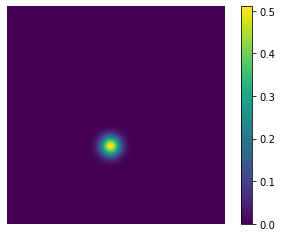

In [35]:
gen = Generator_Basic(latent_dim = 3)
print("gen created")

z = np.random.uniform(0, 1, (10, 3))
z = torch.FloatTensor(z)
# z[:, 2] = 2
gen_img = gen(z).detach().cpu().numpy()
print("10 images output size:", gen_img.shape)
print("Intensity selected:", gen.model(z)[0, -1].item())

plt.imshow(gen_img[0, 0, :, :])
plt.axis('off')
plt.colorbar()
plt.show()


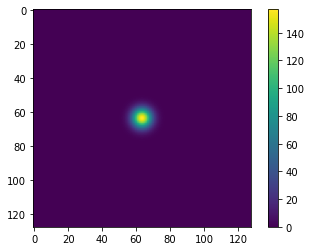

156.7070567063135


In [36]:
x = np.linspace(0, 1, 128)
y = np.linspace(0, 1, 128)
X, Y = np.meshgrid(x, y)
a = np.vstack((X.ravel(), Y.ravel())).T
temp = stats.multivariate_normal.pdf(x    = a, 
                                     mean = [0.5, 0.5], 
                                     cov  = 1e-3
                                ).reshape(128,128)
plt.imshow(temp)
plt.colorbar()
plt.show()

print(np.max(temp))

In [37]:
class Discriminator_Basic(nn.Module):
    def __init__(self, ngpu = 1, latent_dim = None) -> None:
        super().__init__()
        self.ngpu = ngpu
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels  = 1,
                out_channels = 64,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels  = 64,
                out_channels = 128,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels  = 128,
                out_channels = 256,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels  = 256,
                out_channels = 512,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(
                in_channels  = 512,
                out_channels = 1024,
                kernel_size  = 4,
                stride       = 2,
                padding      = 1
            ),
            nn.LeakyReLU(negative_slope=0.2)
        )

        self.last_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
              in_features  = 1024*4**2,
              out_features = 1
            ),
            nn.Sigmoid()
        )
        self.model = nn.Sequential(
            self.conv1,
            self.conv2,
            self.conv3,
            self.conv4,
            self.conv5,
            self.last_layer
        )
    def forward(self, img):
        # print(img.shape)
        if img.is_cuda and self.ngpu > 0:
            ret = nn.parallel.data_parallel(self.model, img, range(self.ngpu))
        else:
            ret = self.model(img)
        return ret
    

In [38]:
disc = Discriminator_Basic()

disc_output = disc(torch.tensor(gen_img))
print(disc_output.shape)


torch.Size([10, 1])


In [62]:
class GAN_Basic(object):
    def __init__(self, identifier,
                 latent_dim,
                 cuda = False, ngpu = 1):
        self.cuda = cuda
        self.ngpu = 0 if not self.cuda else ngpu
        if torch.cuda.is_available() and not self.cuda:
            print("[WARNING] Probably better to run with your CUDA device? It'll be faster, I promise")
        self.device = torch.device("cuda" if self.cuda else "cpu")
        self.Tensor = torch.cuda.FloatTensor if self.cuda else torch.FloatTensor

        self.latent_dim = latent_dim
        self.latent_vector_sampler = self._get_default_latent_vector_sampler()

        self.identifier = identifier
        _root = os.path.dirname(os.path.abspath('./code'))
        self.output_path = os.path.join(os.path.join(_root, "output"))
        self.experiment_path = os.path.join(self.output_path, identifier)

        self.generator = Generator_Basic(ngpu=ngpu, latent_dim=latent_dim)
        self.discriminator = Discriminator_Basic(ngpu=ngpu, latent_dim=latent_dim)

        self.generator.apply(self._weights_init_normal).to(device=self.device)
        self.discriminator.apply(self._weights_init_normal).to(device=self.device)

        self.l1_loss = torch.nn.L1Loss().to(device=self.device)

        # Defining a model parameters dictionary for convenience later on
        self.model_params = {
            "latent_dim": latent_dim, 
            "sampler": "normal"
        }

        # open('../output/training_single_simple_'+ str(self.latent_dim)+'/temp_g.pickle', 'x')
        # open('../output/training_single_simple_'+ str(self.latent_dim)+'/temp_d.pickle', 'x')

        # print(self.generator)
        # print(self.discriminator)

    def _eval_generator_loss(self, real_imgs, gen_imgs, l_l1):
        loss = -torch.mean(self.discriminator(gen_imgs))
        if l_l1 != 0.:
            real_ps = torch.var(real_imgs, dim=[-1, -2])
            gen_ps = torch.var(gen_imgs, dim=[-1, -2])
            loss = loss + l_l1 * self.l1_loss(real_ps, gen_ps)

        return loss
  
    def _eval_discriminator_loss(self, real_imgs, gen_imgs, l_gp):
        # determine the interpolation point 

        eps = self.Tensor(np.random.random((real_imgs.data.size(0), 1, 1, 1)))
        interp_data = (eps * real_imgs.data + ((1 - eps) * gen_imgs.data)).requires_grad_(True)
        disc_interp = self.discriminator(interp_data)
        storage = Variable(self.Tensor(real_imgs.data.shape[0], 1).fill_(1.0), requires_grad=False)
        # compute gradient w.r.t. interpolates

        gradients = autograd.grad(
            outputs=disc_interp,
            inputs=interp_data,
            grad_outputs=storage,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]

        # real_vec = Reshape(128*128)(real_imgs)
        # geni_vec = Reshape(128*128)(gen_imgs)

        # print(real_vec.shape, geni_vec.shape)

        gradients = gradients.view(gradients.size(0), -1)
        GP = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        ret = -torch.mean(self.discriminator(real_imgs)) + torch.mean(self.discriminator(gen_imgs)) + l_gp* GP
        return ret

    def _get_default_latent_vector_sampler(self):
        np.random.randn
        return lambda x, y: np.random.rand(x, y)
    
    def _update_latent_vector_sampler(self, new_sampler):
        self.latent_vector_sampler = new_sampler

    def _get_latent_vector(self, nbatch, seed=None):
        if seed is not None:
            np.random.seed(seed)
        return Variable(self.Tensor(self.latent_vector_sampler(nbatch, self.latent_dim)))

    def _get_optimizers(self, lr, betas):
        # lr, betas = kwargs['lr'], kwargs["betas"]
        opt_gen = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=betas)
        opt_disc = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=betas)
        return opt_gen, opt_disc

    def _weights_init_normal(self, layer):
        classname = layer.__class__.__name__
        if classname.find("Conv") != -1:
            nn.init.normal_(layer.weight.data, 0.0, 0.02)
        elif classname.find("BatchNorm2d") != -1:
            nn.init.normal_(layer.weight.data, 1.0, 0.02)
            nn.init.constant_(layer.bias.data, 0.0)

    def plot_and_save(self, g_losses, d_losses, place_to_save):
        fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(10,8), sharex=True)
        # fig.tight_layout(pad=2.0)

        temp = []
        # Reading the file
        if os.path.exists('output/' + self.identifier + '/learning/temp_d.pickle'):
            with open('output/' + self.identifier + '/learning/temp_d.pickle', 'rb') as handle:
                temp = pickle.load(handle)
            # Appending the read data
            d_losses = np.append(temp, d_losses)
                            

        d_l = []
        for i in range(0, d_losses.size, N_CRITICS):
            d_l.append(d_losses[i])
        d_l = np.array(d_l)

        ax1.plot(d_l)

        temp = []
        # Reading the file
        if os.path.exists('output/' + self.identifier + '/learning/temp_g.pickle'):
            with open('output/' + self.identifier + '/learning/temp_g.pickle', 'rb') as handle:
                temp = pickle.load(handle)
            # Appending the read data
            g_losses = np.append(temp, g_losses)

        ax2.plot(g_losses)
        
        len_combined = min(g_losses.size, d_losses.size)
        comb_losses = g_losses[-len_combined:] + d_l[-len_combined:]

        ax3.plot(comb_losses)

        ax1.set_ylabel("Discriminator\nloss", fontsize=14)
        ax2.set_ylabel("Generator\nloss", fontsize=14)
        ax3.set_ylabel("Combined\nloss", fontsize=14)

        # ax1.set_xlabel("Iteration of losses")
        # ax2.set_xlabel("Iteration of losses")
        ax3.set_xlabel("Generator Update Iteration", fontsize=14)

        fig.suptitle('Variation of losses with iterations', fontsize=24)
        fig.savefig(place_to_save)   
        if os.path.exists('output/' + self.identifier + '/learning/temp_d.pickle'):
            os.remove('output/' + self.identifier + '/learning/temp_d.pickle')
        if os.path.exists('output/' + self.identifier + '/learning/temp_g.pickle'):
            os.remove('output/' + self.identifier + '/learning/temp_g.pickle') 

    def generate_samples(self, nbatch, seed=None):
        self.generator.eval()
        self.discriminator.eval()
        z = self._get_latent_vector(nbatch, seed)
        return self.generator(z).detach()
    
    def load_states(self, output_path, postfix=""):

        generator_state_file = os.path.join(output_path, "generator_{}.pt".format(postfix))
        discriminator_state_file = os.path.join(output_path, "discriminator_{}.pt".format(postfix))

        try:
            print("loading saved states", postfix)
            self.generator.load_state_dict(torch.load(generator_state_file, map_location=self.device))
            self.discriminator.load_state_dict(torch.load(discriminator_state_file, map_location=self.device))
            print("Loaded saved states")
        except Exception:
            print("FAILED to load saved states")

    def save_states(self, output_path, postfix=""):
        postfix = "" if postfix == "" else "_{}".format(str(postfix))
        print("saving states", postfix)
        generator_state_file = os.path.join(output_path, "generator{}.pt".format(postfix))
        discriminator_state_file = os.path.join(output_path, "discriminator{}.pt".format(postfix))
        saving_point_tracker_file = os.path.join(output_path, "saving_point.txt")
        with open(saving_point_tracker_file, "w") as handle:
            handle.write(postfix)
        torch.save(self.generator.state_dict(), generator_state_file)
        torch.save(self.discriminator.state_dict(), discriminator_state_file)
        print("Saved")

    def train(self, dataloader, 
              nepochs=200, ncritics=5, sample_interval=1000,
              save_interval=5, 
              load_states=True, save_states=True, 
              verbose=True,
              lr=0.0002, betas=(0.5, 0.999), 
              l_gp=10, l_l1=0.0, 
              DUMPING_INTERVAL = 1000,
              place_to_save = 'losses.png',
              **kwargs):
        
        kwargs.update({"nepochs": nepochs, "ncritics": ncritics})
        kwargs.update(self.model_params)

        # Base Setup
        run_id = "learning" 
        run_path = os.path.join(self.experiment_path, run_id)
        artifacts_path = os.path.join(run_path, "artifacts")
        model_path = os.path.join(run_path, "model")

        if not os.path.exists(artifacts_path):
            os.makedirs(artifacts_path)
            
        if not os.path.exists(model_path):
            os.makedirs(model_path)

        self.generator.train()
        self.discriminator.train()

        if load_states:
            self.load_states(model_path)

        self.save_states(model_path, 0)
        # Get Optimizers
        opt_gen, opt_disc = self._get_optimizers(lr, betas)
        batches_done = 0

        g_losses = np.array([])
        d_losses = np.array([])

        for epoch in range(nepochs):

            for i, sample in enumerate(dataloader):

                if g_losses.size > DUMPING_INTERVAL:
                    # If the generator losses become too long, append to the losses in the saved file, and save again
                    temp_g_losses = []
                    # Reading the file
                    if os.path.exists('output/' + self.identifier + '/learning/temp_g.pickle'):
                        with open('output/' + self.identifier + '/learning/temp_g.pickle', 'rb') as handle:
                            temp_g_losses = pickle.load(handle)
                    # Appending the data
                    temp_g_losses = np.append(temp_g_losses, g_losses, axis=0)
                    # Resaving
                    with open('output/' + self.identifier + '.learning/temp_g.pickle', 'wb') as handle:
                        pickle.dump(temp_g_losses, handle, protocol=pickle.HIGHEST_PROTOCOL)
                    # Clearing the data from memory
                    g_losses = np.array([])

                if d_losses.size > DUMPING_INTERVAL:
                    # If the discriminator losses become too long, append to the losses in the saved file, and save again
                    temp_d_losses = []
                    # Reading the file
                    if os.path.exists('output/' + self.identifier + '/learning/temp_d.pickle'):
                        with open('output/' + self.identifier + '/learning/temp_d.pickle', 'rb') as handle:
                            temp_d_losses = pickle.load(handle)
                    # Appending the data
                    temp_d_losses = np.append(temp_d_losses, d_losses, axis=0)
                    # Resaving 
                    with open('output/' + self.identifier + '/learning/temp_d.pickle', 'wb') as handle:
                        pickle.dump(temp_d_losses, handle, protocol=pickle.HIGHEST_PROTOCOL)
                    # Clearing the data from memory
                    d_losses = np.array([])

                imgs = sample[0]
                real_imgs = imgs.to(device)

                # Sample noise as generator input
                z = self._get_latent_vector(imgs.shape[0])

                # Generate a batch of images
                gen_imgs = self.generator(z)
                gen_imgs = gen_imgs.detach().to(device=self.device)

                # Adversarial loss 
                opt_disc.zero_grad()
                loss_D = self._eval_discriminator_loss(real_imgs, gen_imgs, l_l1)
                loss_D.backward()
                opt_disc.step()
                d_losses = np.append(d_losses, loss_D.item())
                print(f'\r[Epoch {epoch+1}/{nepochs}] [Batch {(batches_done+1) % len(dataloader)}/{len(dataloader)}] [D loss: {loss_D.item():.3f}] \t', end='')

                if i % ncritics == 0:
                    opt_gen.zero_grad()

                    # Generate a batch of images
                    gen_imgs = self.generator(z)
                    # Adversarial loss
                    loss_G = self._eval_generator_loss(real_imgs, gen_imgs, l_gp)
                    loss_G.backward()
                    opt_gen.step()
                        
                    g_losses = np.append(g_losses, loss_G.item())
                    
                    
                    if g_losses.size > 200 and d_losses.size > 200:
                        if(np.mean(abs(g_losses[-100:] - g_losses[-200:-100])) / np.mean(abs(g_losses[-200:-100])) < 0.01
                            ) and (np.mean(abs(d_losses[-100:] - d_losses[-200:-100])) / np.mean(abs(d_losses[-200:-100])) < 0.01):
                            if save_states:
                                self.save_states(model_path, nepochs)

                            self.plot_and_save(g_losses, d_losses, place_to_save)
                            return

                if batches_done % sample_interval == 0:
                    temp = torch.cat((real_imgs.data[:1], gen_imgs.data[:5]), 0)
                    temp = temp if gen_imgs.shape[-3] < 4 else torch.unsqueeze(torch.sum(temp, 1), 1)
                    save_image(temp, os.path.join(artifacts_path, "%d.png" % batches_done), normalize=True,
                               nrow=int(temp.shape[0] / 2.))
                batches_done += 1

            if int(epoch + 1) % save_interval == 0 and save_states:
                self.save_states(model_path, int(epoch + 1))
        if save_states:
            self.save_states(model_path, nepochs)

        # plt.plot(d_losses)
        # plt.title("Loss over update iteration")
        # plt.show()
        
        print("Not converged")
        self.plot_and_save(g_losses, d_losses, place_to_save)

## Training the DCGAN

In [63]:
LATENT_DIM = 3
print("Size of latent random vector:", LATENT_DIM)
model = GAN_Basic(
            identifier       = "discriminator_only_" + str(LATENT_DIM), 
            latent_dim       = LATENT_DIM,
            cuda             = torch.cuda.is_available() 
        )



Size of latent random vector: 3


In [64]:
print(model.output_path)

d:\Srishti\Projects\MITACS\backup\trials\output


loading saved states 
FAILED to load saved states
saving states _0
Saved
[Epoch 1/1] [Batch 0/312] [D loss: -1.000] 	saving states _1
Saved
Not converged


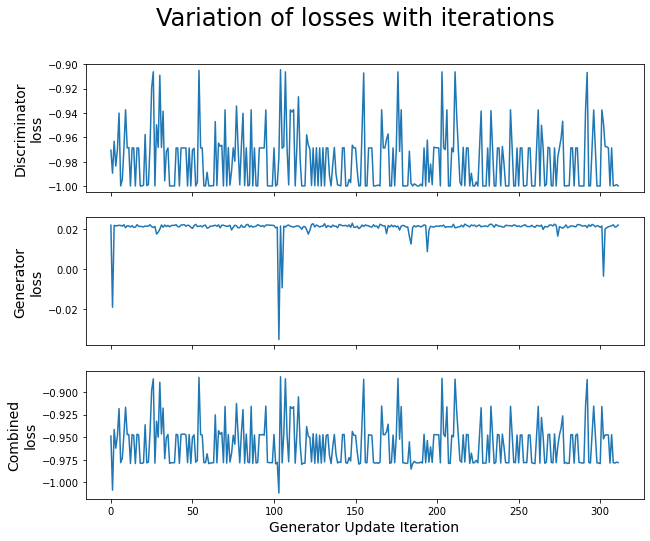

In [67]:
# if not os.path.exists("./generator_Multiple_Gaussian_Blobs_"+str(LATENT_DIM)+"_5_5_4_1_0_1000.pt"):
#     print("Old data not found")
#     break
# model.load_states(pathlib.Path("."), "Multiple_Gaussian_Blobs_"+str(LATENT_DIM)+"_5_5_4_1_0_1000")
    
model.train(
    dataloader      = train_dataLoader,
    nepochs         = 1,
    ncritics        = N_CRITICS,
    sample_interval = SAMPLE_INTERVALS,
    save_interval   = SAVE_INTERVAL,
    load_states     = True,
    save_states     = True,
    verbose         = True,
    mlflow_run      = False,
    lr              = LEARNING_RATE,
    betas           = BETAS,
    l_gp       = L_GP,
    l_l1       = L_l1,
        
    DUMPING_INTERVAL= DUMPING_INTERVAL,
    place_to_save = 'output/' + model.identifier + '/losses.png'
)

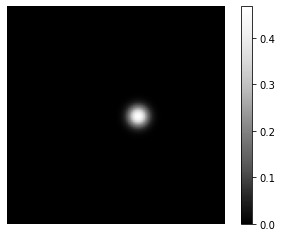

Discriminator score: tensor([[8.5914e-10],
        [1.3785e-09],
        [1.0805e-06],
        [9.5317e-10],
        [1.5572e-08],
        [5.4487e-10],
        [4.9427e-09],
        [6.4350e-10],
        [4.6396e-07],
        [2.1730e-10]], device='cuda:0')
Intensity for generator: tensor([[0.6026, 0.5055, 0.4676],
        [0.6343, 0.4759, 0.5440],
        [0.6722, 0.4422, 0.6050],
        [0.5884, 0.5224, 0.4467],
        [0.6539, 0.4563, 0.5480],
        [0.6057, 0.5101, 0.4915],
        [0.6417, 0.4573, 0.5058],
        [0.5945, 0.5411, 0.5305],
        [0.5592, 0.5666, 0.4313],
        [0.5985, 0.5213, 0.5019]], device='cuda:0', grad_fn=<SliceBackward0>)
Std. dev. of input image blobs: 0.03162277660168379


In [68]:
z = model._get_latent_vector(10)
    # Generate a batch of images
# z[0:5, :] = 0
# z[0:5, -1] = -21
# print(model.generator.model(z))
gen_imgs = model.generator(z).detach().cpu()

plt.imshow(gen_imgs[0,0,:,:], cmap='Greys_r')
plt.axis('off')
plt.colorbar()
plt.show()

print("Discriminator score:", model.discriminator(gen_imgs[:, :, :, :].to(device=model.device)).detach())
print("Intensity for generator:", model.generator.model(z)[:, :])
print("Std. dev. of input image blobs:", np.sqrt(0.001))

In [44]:
images, _  = next(iter(train_dataLoader))

print(model.discriminator(images[0:10, :, :, :].to(device=model.device)))

tensor([[1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000],
        [1.0000]], device='cuda:0', grad_fn=<SigmoidBackward0>)


In [ ]:
    # The numbers are read (LATENT_DIM)_(N_CONV_LATER_GEN)_(N_CONV_LATER_DISC)_(KERNEL_SIZE)_(PADDING)_(OUTPUT_PADDING)_(TRAINING_EPOCHS)
    # model.save_states(pathlib.Path("."), "Single_Gaussian_Blobs_" + str(LATENT_DIM) + '_5_5_4_1_0_' + str(N_EPOCHS))
SAVING_DIR = 'datasets_for_Statistician/Full_model__single_blob_simple_' + str(LATENT_DIM) + '_5_5_4_1_0_' + str(N_EPOCHS) + '/generated_data/'
os.makedirs(SAVING_DIR, exist_ok=True)

for n in range(BATCHES_TO_SAVE):
    z = model._get_latent_vector(BATCH_SIZE)
    # Generate a batch of images
    gen_imgs = model.generator(z).detach().cpu()
        
    for i in range(BATCH_SIZE):
        frame = gen_imgs.numpy()[i, 0, :, :]
        frame = frame - np.min(frame)
        frame = frame * 255 / np.max(frame)
        frame = frame.astype(np.uint8)

        img = Image.fromarray(frame)# .convert('RGB')
        print(f'\r{n*BATCH_SIZE + i + 1} / {BATCHES_TO_SAVE * BATCH_SIZE}', end='')
        img.save(SAVING_DIR + str((n * BATCH_SIZE) + i) + '.jpg')    

print('\n') 